# Interconnect Churn Model Project 

## Introduction

In this project, we aim to develop a machine learning model to forecast client churn for the telecom operator Interconnect. Churn prediction is critical for retaining customers, as it allows the company to proactively offer promotions or custom plans to at-risk clients. The target variable in this dataset is the EndDate column, where "No" indicates a non-churning client.

Our goal is to:

- Explore and clean the datasets.
- Engineer and preprocess features.
- Build and evaluate a machine learning model optimized for the AUC-ROC metric.
- Achieve a minimum AUC-ROC score of 0.75, aiming for the highest possible score.

The project involves exploratory data analysis (EDA) and model development. The final model will help Interconnect reduce churn and retain valuable customers.

## Import Libraries and Load Data

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression


In [5]:
# Loading datasets
contract = pd.read_csv('\\Users\\Brian4\\Downloads\\contract.csv')
personal = pd.read_csv('\\Users\\Brian4\\Downloads\\personal.csv')
internet = pd.read_csv('\\Users\\Brian4\\Downloads\\\internet.csv')
phone = pd.read_csv('\\Users\\Brian4\\Downloads\\phone.csv')

In [6]:
# Display the first few rows of each dataset to inspect their structure
print("Contract Data:")
display(contract.head())
print("Personal Data:")
display(personal.head())
print("Internet Data:")
display(internet.head())
print("Phone Data:")
display(phone.head())


Contract Data:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Personal Data:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Internet Data:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Phone Data:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
print("Contract Data:")
display(contract.info())
print("Personal Data:")
display(personal.info())
print("Internet Data:")
display(internet.info())
print("Phone Data:")
display(phone.info())

Contract Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Personal Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Internet Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Phone Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

## Merge Data on 'customerID'

In [9]:
# Merge the datasets on 'customerID'
data = pd.merge(contract, personal, on='customerID', how='left')
data = pd.merge(data, internet, on='customerID', how='left')
data = pd.merge(data, phone, on='customerID', how='left')

# Display the first few rows of the merged dataset to inspect the result
display(data.head())


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## Data Preprocessing

In [11]:
# Convert 'BeginDate' and 'EndDate' to datetime
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')  

# Replace NaN values with 'No Service'
columns_with_nan = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in columns_with_nan:
    data[column] = data[column].fillna('No Service')

# Create a churn column where churn = 1 if EndDate is not null, churn = 0 if EndDate is null
data['churn'] = np.where(data['EndDate'].isnull(), 0, 1)

# Replace "No" in the EndDate column with NaT for active customers
data['EndDate'] = data['EndDate'].replace("No", np.nan)


In [12]:
# Engineer tenure: Calculate the difference between EndDate and BeginDate in months
data['tenure'] = ((data['EndDate'].fillna(pd.Timestamp.now()) - data['BeginDate']).dt.days // 30)

In [13]:
# Identify categorical variables that need one-hot encoding
categorical_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                      'TechSupport', 'StreamingTV', 'StreamingMovies']

# One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)



In [14]:
# Convert 'gender' from 'Male'/'Female' to 1/0
data['gender'] = (data['gender'] == 'Male').astype(int)

# List of binary categorical columns with 'Yes'/'No' values
binary_columns_yes_no = ['Partner', 'Dependents', 'PaperlessBilling']

# Convert 'Yes'/'No' binary categorical columns to 1/0
for column in binary_columns_yes_no:
    data[column] = (data[column] == 'Yes').astype(int)

In [15]:
# List of numerical features
numerical_features = ['MonthlyCharges', 'tenure', 'TotalCharges']

# Convert to numeric and handle NaNs
for feature in numerical_features:
    data[feature] = pd.to_numeric(data[feature], errors='coerce')  # Ensures conversion to numeric, NaN if fails
    data[feature].fillna(data[feature].median(), inplace=True)  # Impute NaNs with median

# Scaling numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [16]:
display(data.head())

# Check for missing values
print("Missing Values:")
display(data.isnull().sum())

# Check for duplicate entries
duplicates = data.duplicated().sum()
print(f"Number of duplicate entries: {duplicates}")

# Check data types
print("Data Types:")
display(data.dtypes)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineBackup_No Service,OnlineBackup_Yes,DeviceProtection_No Service,DeviceProtection_Yes,TechSupport_No Service,TechSupport_Yes,StreamingTV_No Service,StreamingTV_Yes,StreamingMovies_No Service,StreamingMovies_Yes
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,-1.160323,-0.994242,0,0,...,False,True,False,False,False,False,False,False,False,False
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,-0.259629,-0.173244,1,0,...,False,False,False,True,False,False,False,False,False,False
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,-0.362660,-0.959674,1,0,...,False,True,False,False,False,False,False,False,False,False
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),-0.746535,-0.194766,1,0,...,False,False,False,True,False,True,False,False,False,False
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,0.197365,-0.940470,0,0,...,False,False,False,False,False,False,False,False,False,False


Missing Values:


customerID                        0
BeginDate                         0
EndDate                        5174
Type                              0
PaperlessBilling                  0
PaymentMethod                     0
MonthlyCharges                    0
TotalCharges                      0
gender                            0
SeniorCitizen                     0
Partner                           0
Dependents                        0
InternetService                1526
MultipleLines                   682
churn                             0
tenure                            0
OnlineSecurity_No Service         0
OnlineSecurity_Yes                0
OnlineBackup_No Service           0
OnlineBackup_Yes                  0
DeviceProtection_No Service       0
DeviceProtection_Yes              0
TechSupport_No Service            0
TechSupport_Yes                   0
StreamingTV_No Service            0
StreamingTV_Yes                   0
StreamingMovies_No Service        0
StreamingMovies_Yes         

Number of duplicate entries: 0
Data Types:


customerID                             object
BeginDate                      datetime64[ns]
EndDate                        datetime64[ns]
Type                                   object
PaperlessBilling                        int32
PaymentMethod                          object
MonthlyCharges                        float64
TotalCharges                          float64
gender                                  int32
SeniorCitizen                           int64
Partner                                 int32
Dependents                              int32
InternetService                        object
MultipleLines                          object
churn                                   int32
tenure                                float64
OnlineSecurity_No Service                bool
OnlineSecurity_Yes                       bool
OnlineBackup_No Service                  bool
OnlineBackup_Yes                         bool
DeviceProtection_No Service              bool
DeviceProtection_Yes              

## Exploratory Data Analysis (EDA)

### Analyze the Target Variable Distribution

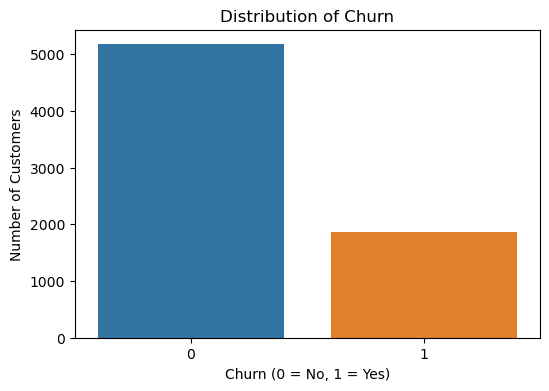

In [19]:
# Analyze the distribution of the churn variable
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=data)
plt.title('Distribution of Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.show()

<b>Churn Distribution:</b> There's a clear imbalance in the dataset with a significantly higher number of customers not churning (Churn = 0) compared to those who do churn (Churn = 1). This imbalance is common in churn datasets but requires specific handling techniques during model training to ensure that the minority class is appropriately represented.

### Analyze Numerical Features

C:\Users\Brian4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Brian4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Brian4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


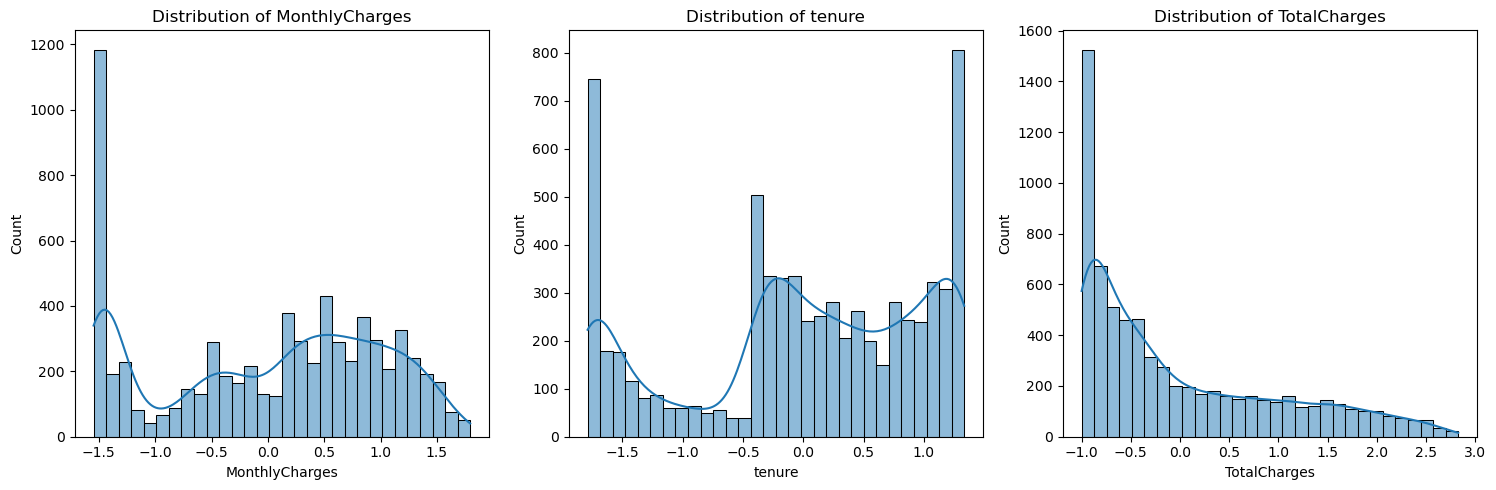

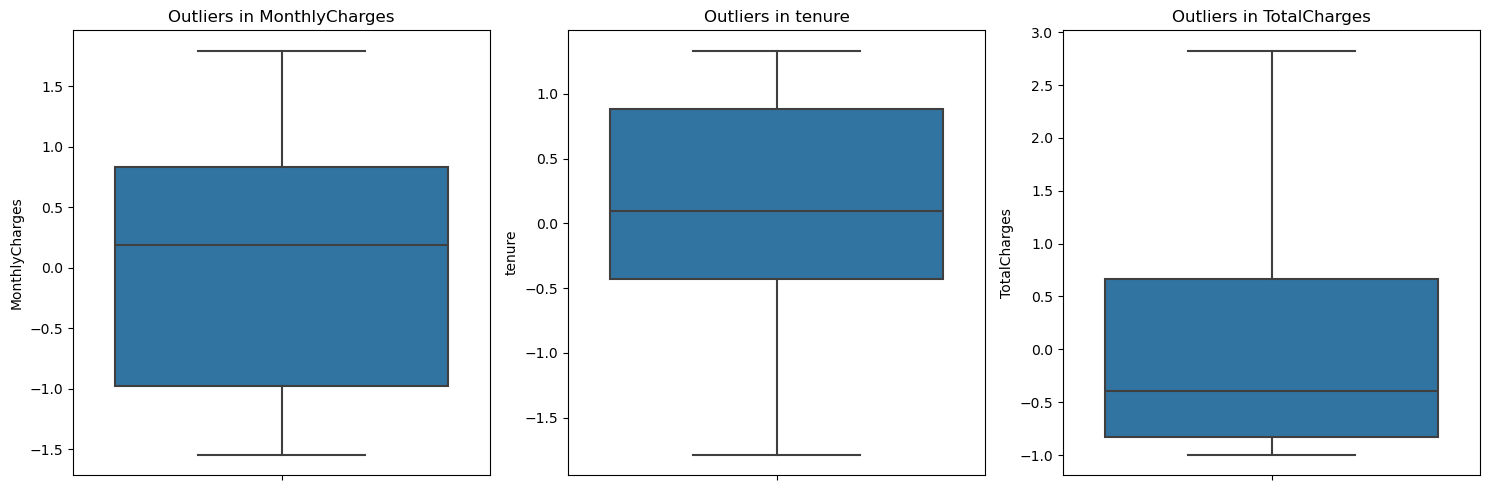

In [22]:
# Histograms for numerical features
numerical_features = ['MonthlyCharges', 'tenure', 'TotalCharges']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Box plots for numerical features to check for outliers
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=data[col])
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

<b>Distribution of Numerical Features</b>

- <b>Monthly Charges:</b> The distribution shows a bimodal behavior with two peaks, which suggests different groups of customers based on the monthly charges they incur. This could be reflecting different service packages or customer preferences.

- <b>Tenure:</b> The distribution is somewhat uniform but with spikes at the beginning and end. A high number of new customers and those with long tenure might indicate loyal customers along with a constant inflow of new customers. The spike at the lower end could represent customers who leave the service early, indicating potential issues in customer retention.

- <b>Total Charges:</b> Skewed to the right, indicating that most customers have lower cumulative charges, consistent with a high turnover among newer subscribers or those with lower service plans.

<b>Boxplots of Numerical Features</b>

- <b>Monthly Charges:</b> Few outliers, suggesting that most customers fall within a predictable range of monthly spending.

- <b>Tenure and Total Charges:</b> Outliers in both these features suggest variations in customer lifecycle and spending that could be significant for understanding different customer behaviors.

### Analyze Categorical Features

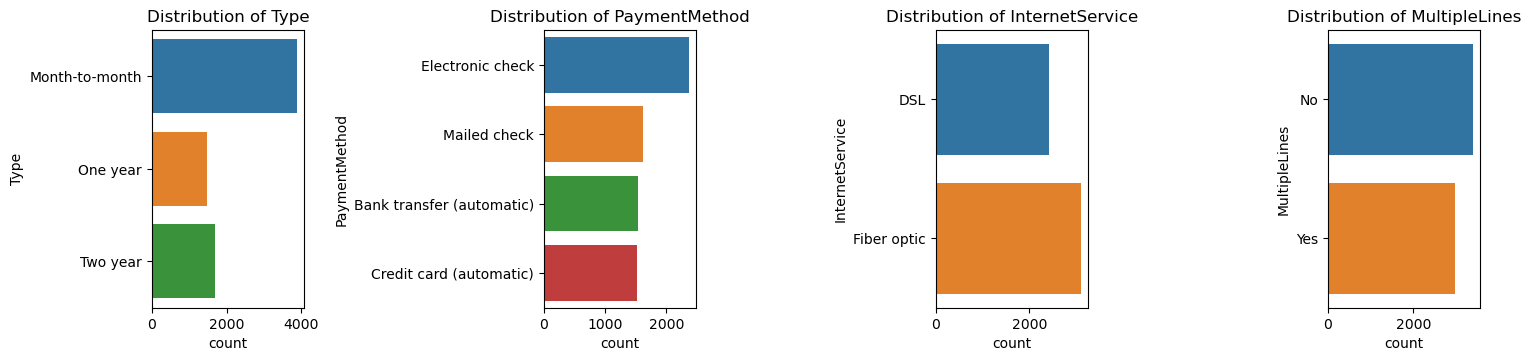

In [25]:
# Categorical features analysis
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features.remove('customerID')  # Exclude the customerID

plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 4, i + 1)
    sns.countplot(y=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
plt.show()


<b>Distribution of Categorical Features</b>

- <b>Contract Type:</b> Most customers are on month-to-month plans, indicating potentially higher churn rates as these plans typically offer less stability in customer retention compared to one-year or two-year contracts.
- <b>Payment Method:</b> The dominant method is electronic check, which might indicate a younger or more tech-savvy demographic. Different payment methods might impact churn due to convenience or financial management preferences.
- <b>Internet Service:</b> A significant number of customers use DSL or Fiber optic services. The choice of internet service can significantly affect customer satisfaction and churn, depending on the quality and reliability of the service.
- <b>Multiple Lines:</b> Almost a 50/50 split between customers with and without multiple lines, indicating diverse needs and possibly different family or business uses within the customer base.

## Model Training 

### Model Data Preprocessing 

In [29]:
# Drop 'EndDate' 
data.drop(columns=['EndDate', 'BeginDate'], inplace=True)

# Handle missing values
data['InternetService'] = data['InternetService'].fillna('No Service')
data['MultipleLines'] = data['MultipleLines'].fillna('No Service')

# One-hot encode categorical columns
additional_categoricals = ['Type', 'PaymentMethod', 'InternetService', 'MultipleLines']
data = pd.get_dummies(data, columns=additional_categoricals, drop_first=True)

# Convert boolean to int
boolean_columns = [col for col in data.columns if data[col].dtype == bool]
data[boolean_columns] = data[boolean_columns].astype(int)

# Confirm changes
print("Data types after adjustments:")
print(data.dtypes)


Data types after adjustments:
customerID                                object
PaperlessBilling                           int32
MonthlyCharges                           float64
TotalCharges                             float64
gender                                     int32
SeniorCitizen                              int64
Partner                                    int32
Dependents                                 int32
churn                                      int32
tenure                                   float64
OnlineSecurity_No Service                  int32
OnlineSecurity_Yes                         int32
OnlineBackup_No Service                    int32
OnlineBackup_Yes                           int32
DeviceProtection_No Service                int32
DeviceProtection_Yes                       int32
TechSupport_No Service                     int32
TechSupport_Yes                            int32
StreamingTV_No Service                     int32
StreamingTV_Yes                        

### Spliting Data

In [31]:

# Define features and target
X = data.drop(['customerID', 'churn', 'tenure'], axis=1)  
y = data['churn']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (5634, 28)
Testing set size: (1409, 28)


### Base Model (Logistic Regression) 

In [33]:
# Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the model
log_reg_auc = roc_auc_score(y_test, y_pred_proba)
log_reg_accuracy = accuracy_score(y_test, y_pred)

print(f"Logistic Regression AUC-ROC: {log_reg_auc}")
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")

Logistic Regression AUC-ROC: 0.8546702102332129
Logistic Regression Accuracy: 0.8183108587650816


### Random Forest Model

In [35]:
# Set up GridSearchCV for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Evaluate Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Best Params: {grid_search_rf.best_params_}")
print(f"Random Forest AUC-ROC: {rf_auc}")
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest AUC-ROC: 0.8625707764447711
Random Forest Accuracy: 0.8026969481902059


### Gradient Boosting Model

In [37]:
# Set up GridSearchCV for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Evaluate Gradient Boosting
best_gb = grid_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
y_pred_proba_gb = best_gb.predict_proba(X_test)[:, 1]

gb_auc = roc_auc_score(y_test, y_pred_proba_gb)
gb_accuracy = accuracy_score(y_test, y_pred_gb)

print(f"Gradient Boosting Best Params: {grid_search_gb.best_params_}")
print(f"Gradient Boosting AUC-ROC: {gb_auc}")
print(f"Gradient Boosting Accuracy: {gb_accuracy}")

Gradient Boosting Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Gradient Boosting AUC-ROC: 0.8624569130601301
Gradient Boosting Accuracy: 0.8140525195173882


Both Random Forest and Gradient Boosting demonstrated robust performance, significantly exceeding our initial AUC-ROC target of 0.75. They performed similarly in terms of AUC-ROC, but the Gradient Boosting model provided a slightly higher accuracy.

# Solution Report 

<b>Steps of the Work Plan Performed:</b>

Step 1: Understanding the data was completed while taking into account the proposed changes of the work plan. All proposed changes were necessary and implemented for the model. 

Step 2: Through exploratory data analysis (EDA), significant insights were gathered regarding the distribution of churn, the impact of various service features, and customer demographics.

Step 3: Cleaned and prepared the data for model training by handling missing values and duplicates, encoding categorical features, and scaling numerical features

Step 4: Developed and evaluted three models. Linear Regression, Random Forest and Gradient Boodsting

Step 5: Highlight actionable insights for the business: Key features influencing churn, such as contract type, payment method, and service options, were identified. These insights are valuable for tailoring customer retention strategies.

Step 6: Detail the model's performance metrics (AUC-ROC and accuracy): Both the Random Forest and Gradient Boosting models were evaluated, and their performance metrics were thoroughly reported. The models were optimized using GridSearchCV, and the results showed strong performance, particularly with the Gradient Boosting model, which exceeded the initial AUC-ROC target.


<b>Steps Skipped</b>

All the primary steps outlined in the work plan were addressed.

<b>Difficulties Encountered and Solutions</b>

Data Leakage: While traning the models initially, the tenure column was included in the dataset resulting in a perfect AUC-ROC and accuracy score. To address this data leakage I removed the tenure feature from the data so that the model could not access any information about the target feature.

<b>Key Steps to Solving the Task</b>

Preprocessing and Feature Engineering: Ensuring data quality, handling missing data effectively, and engineering relevant features were crucial steps that set the foundation for successful model training.

Comprehensive Model Evaluation: Employing both AUC-ROC and accuracy metrics provided a balanced view of the models’ performance, ensuring the selected model performed well across different aspects of the prediction task.

Effective Use of Machine Learning Techniques: The use of advanced algorithms like Gradient Boosting and Random Forest, along with methodical hyperparameter tuning, was key to developing a highly effective predictive model.

<b>Final Model and Quality Score</b>

Final Model: The Gradient Boosting model was selected as the final model due to its slightly better performance metrics compared to Random Forest.

Quality Score: The Gradient Boosting model achieved an AUC-ROC of 0.8625 and an accuracy of 81.41%. These scores are excellent for churn prediction tasks, indicating a high degree of predictive accuracy and the model’s strong capability to differentiate between the churn and non-churn classes.
In conclusion, the project effectively met the objectives set out in the work plan by utilizing data-driven insights and  analytical techniques to develop a predictive model that can significantly aid in reducing customer churn. 